In [65]:
# https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend

import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [183]:
import skimage.data
import skimage.transform
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.initializers import glorot_uniform, he_normal
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator, array_to_img

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, classification_report,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, LeaveOneOut, KFold, cross_val_score,cross_val_predict
from sklearn.neighbors import KNeighborsClassifier 

In [67]:
#code tutorial
#https:////github.com//PacktPublishing//Practical-Convolutional-Neural-Networks//blob//master//Chapter03//Traffic//custom.py

# Train_IMAGE_DIR = "C://New folder//OneDrive//ai class//Final Project//BelgiumTSC_Training//"
# Test_IMAGE_DIR = "C://New folder//OneDrive//ai class//Final Project//BelgiumTSC_Testing//"

Train_IMAGE_DIR = 'C:/Users/bipul/niva/BelgiumTSC_Training/'
Test_IMAGE_DIR = 'C:/Users/bipul/niva/BelgiumTSC_Testing/'

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all the subdirectories of the data folder (i.e. traing or test). Each folder represents an unique label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    
    # Iterate for loop through the label directories and collect the data in two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".ppm")]

        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels



# images1, labels1 = load_data(Train_IMAGE_DIR)
# images2, labels2 = load_data(Test_IMAGE_DIR)


# Load training and testing datasets.
train_data_dir = os.path.join(Train_IMAGE_DIR, "Training")
test_data_dir = os.path.join(Test_IMAGE_DIR, "Testing")

images1, labels1 = load_data(train_data_dir)
images2, labels2 = load_data(test_data_dir)

#combine training and testing data

images = images1 + images2
labels = labels1 + labels2

In [68]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))


Unique Labels: 62
Total Images: 7095


DATA VISUALIZATION FOR VISUAL ANALYSIS

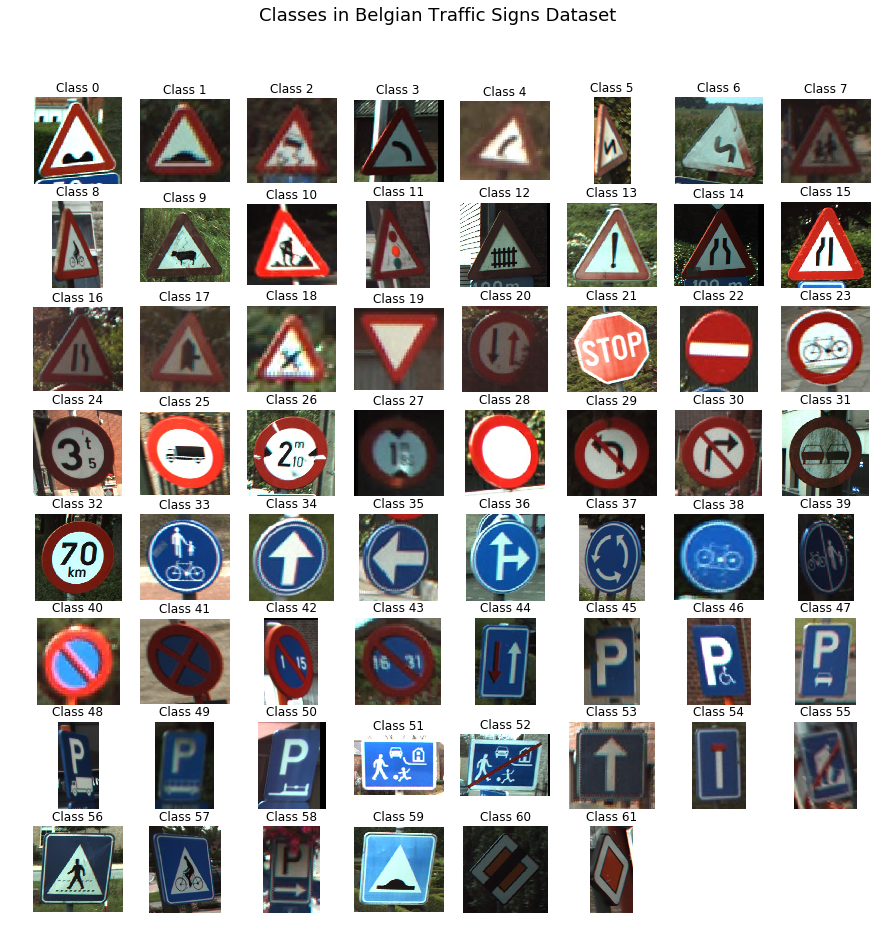

In [6]:
"display differnt class types"

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Class {0}".format(label))
        i += 1
        _ = plt.imshow(image)
        plt.suptitle("Classes in Belgian Traffic Signs Dataset", y=0.964,fontsize=18)
#         plt.savefig("traffic_class.png")
    plt.show()

display_images_and_labels(images, labels)

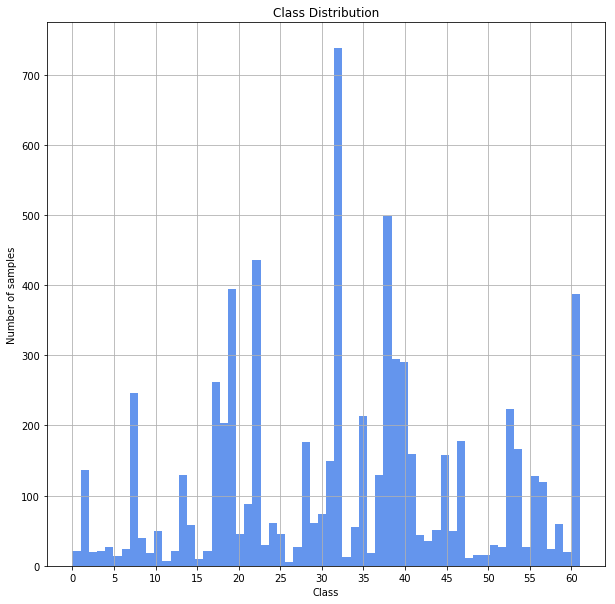

In [10]:
"display histogram of class distribution"

plt.figure(figsize=[10,10])
plt.hist(labels,bins=62, color='cornflowerblue') 
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.xticks(ticks=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.title("Class Distribution")
plt.grid(True)
# plt.savefig("traffic_classDist.png")
plt.show()


In [53]:
"count of samples in each class"

values, counts = np.unique(labels, return_counts=True)
counts
max_value = max(counts)
min_value = min(counts)
avg_value = sum(counts)/62
print(max_value, min_value,avg_value)
# counts

738 6 114.43548387096774


DATA PREPROCESSING : ZERO-CENTER, RESIZE, EQUAL CLASS DISTRIBUTION

In [69]:
"Resize images"

images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]

"convert from list to array "
images_array = np.array(images32)

"convert to float and scale pixel value "
images_array = images_array.astype('float32') / 255.

In [55]:
"Compare images"

'Compare images'

In [ ]:
b=np.std(images32)
b

plt.imshow(images[i])

plt.imshow(images32[i])
   


MODEL 1 :KNN

USE 2-TIER SCHEME TO TUNE PARAMETERS
EVALUATE USING LOO
IMAGE AUMENTATION
K FOLD CROSS VALIDATION

In [70]:
"flatten 3D array to 1D"
images_as_rows = images_as_rows.reshape(7095, 3072)

"split data using 2-tier scheme"

(X_train, X_test, y_train, y_test) = train_test_split(images_as_rows,labels,test_size=0.25, random_state=42)

"zero-center images based on training data statistics"

scaler= StandardScaler(with_std=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# http://cs231n.github.io/neural-networks-2/#datapre

# y_train = np_utils.to_categorical(y_train, 62)
# y_test = np_utils.to_categorical(y_test, 62)

In [71]:
X_train.shape

(5321, 3072)

In [72]:
 
kVals = range(1, 30, 2)
accuracies = []
train_acc = []
test_acc= []

for k in range(1, 30, 2):
  
    model_1 = KNeighborsClassifier(n_neighbors=k)
    model_1.fit(X_train, y_train)
    
    y_predict_train = model_1.predict(X_train)
    y_pred_test = model_1.predict(X_test)
    
    train_acc.append(accuracy_score(y_train, y_predict_train))
    test_acc.append(accuracy_score(y_test, y_pred_test))
    score = model_1.score(X_test, y_test)
   
    accuracies.append(score)
 
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on test data" % (kVals[i],
	accuracies[i] * 100))



k=1 achieved highest accuracy of 86.25% on test data


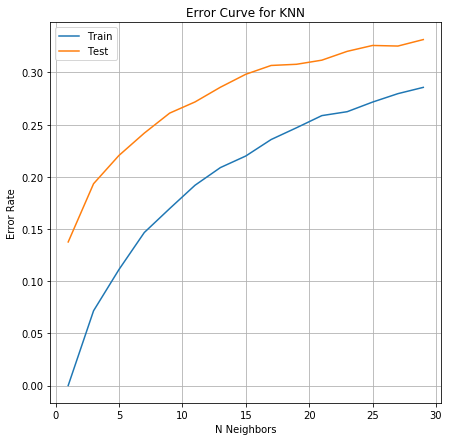

In [82]:
train_error = [1-x for x in train_acc ]
test_error = [1-x for x in test_acc ]
# n=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
plt.title('Error Curve for KNN')
plt.plot(n,train_error)
plt.plot(n,test_error)
plt.ylabel('Error Rate')
plt.xlabel('N Neighbors')
plt.legend(['Train', 'Test'], loc='best')
plt.savefig("knn_error.png")
plt.grid(True)
plt.show()

In [135]:
"create a knn model"

model_knn = KNeighborsClassifier(n_neighbors=1)


In [136]:
"validate using LOO"


loo_1 = LeaveOneOut()
loo_1_scores = cross_val_score(model_knn,images_as_rows,labels,cv=loo_1)
print(loo_1_scores.mean())



0.900352360817477


LOO average accuracy = 0.900352360817477

In [141]:
"create a data generator"

datagen = ImageDataGenerator(horizontal_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )

In [142]:
def data_augment(img):
    
    img_aug=next(datagen.flow(img, batch_size=1))
    
    return(img_aug)

In [147]:
images_array=images_array.reshape(images_array.shape[0], 32,32,3)


In [148]:
#tutorial
#https://towardsdatascience.com/my-tryst-with-deep-learning-german-traffic-data-set-with-keras-87970dfb18b7

labels_array= np.asarray(labels)

X_train_aug = []
y_train_aug = []
X_aug_1 = []
Y_aug_1 = []



for i in range(0,62):
    
    class_records=np.where(labels_array==i)[0].size
    max_records=200
    samples=images_array[np.where(labels_array==i)[0]]  
    X_aug=[]
    Y_aug=[i]*max_records
    for x in range(max_records):
        img=samples[x % class_records]
        img=img.reshape((1,) + img.shape)
        trans_img=data_augment(img)
        trans_img=trans_img.reshape(32,32,3)
        X_aug.append(trans_img)
    X_train_aug = X_train_aug + X_aug
    y_train_aug = y_train_aug + Y_aug

    Y_aug_1 = Y_aug_1 + Y_aug
    X_aug_1 = X_aug_1 + X_aug



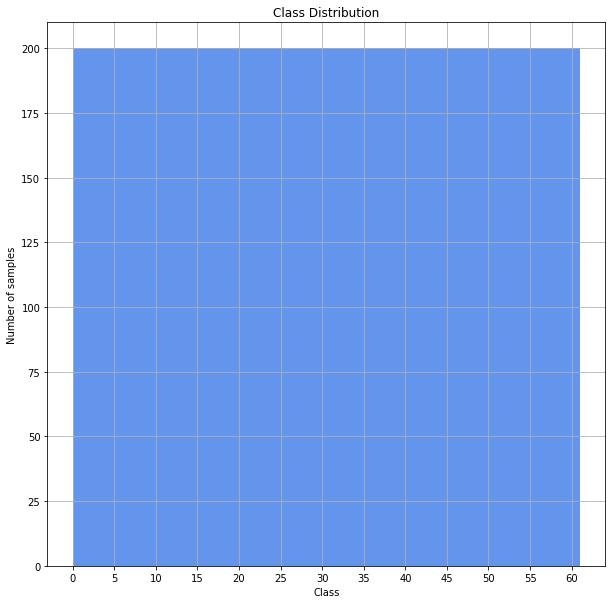

In [149]:
"display histogram of class distribution"
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.hist(Y_aug_1,bins=62, color='cornflowerblue') 
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.xticks(ticks=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.title("Class Distribution")
plt.grid(True)
# plt.savefig("traffic_classDist.png")
plt.show()


In [150]:
"convert from list to array"

new_label= np.asarray(Y_aug_1)
new_data= np.asarray(X_aug_1)


In [151]:
"divide data into 4 folds"

kf = KFold(n_splits=4)
fold1, fold2, fold3, fold4 = kf.split(new_data)

xtrain1,xtest1=new_data[fold1[0]],new_data[fold1[1]]
ytrain1,ytest1=new_label[fold1[0]],new_label[fold1[1]]

xtrain2,xtest2=new_data[fold2[0]],new_data[fold2[1]]
ytrain2,ytest2=new_label[fold2[0]],new_label[fold2[1]]

xtrain3,xtest3=new_data[fold3[0]],new_data[fold3[1]]
ytrain3,ytest3=new_label[fold3[0]],new_label[fold3[1]]

xtrain4,xtest4=new_data[fold4[0]],new_data[fold4[1]]
ytrain4,ytest4=new_label[fold4[0]],new_label[fold4[1]]




In [198]:
def get_eval(X_train, X_test, y_train, y_test):
    
    scaler= StandardScaler(with_std=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  
    model_1 = KNeighborsClassifier(n_neighbors=1)
    model_1.fit(X_train, y_train)
    
    knn_pred= model_1.predict(X_test)
    report1= classification_report(y_test,knn_pred)
    print(report1)
    
    score = model_1.score(X_test, y_test)
    print(score)
    
#     knn_predict_proba = model_1.predict(X_test).ravel()
#     fpr, tpr, thresholds = roc_curve(y_test,knn_predict_proba)
#     auc= auc(fpr, tpr)
    
    return(score)
   

In [194]:
def reshape (x,y):
    a=x.reshape(len(x),3072)
    b=y.reshape(len(y),3072)
    return(a,b)


xtrain1,xtest1 = reshape(xtrain1,xtest1)
xtrain2,xtest2 = reshape(xtrain2,xtest2)
xtrain3,xtest3 = reshape(xtrain3,xtest3)
xtrain4,xtest4 = reshape(xtrain4,xtest4)



In [202]:
score1 = get_eval(xtrain1,xtest1,ytrain1,ytest1)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       200
           4       0.00      0.00      0.00       200
           5       0.00      0.00      0.00       200
           6       0.00      0.00      0.00       200
           7       0.00      0.00      0.00       200
           8       0.00      0.00      0.00       200
           9       0.00      0.00      0.00       200
          10       0.00      0.00      0.00       200
          11       0.00      0.00      0.00       200
          12       0.00      0.00      0.00       200
          13       0.00      0.00      0.00       200
          14       0.00      0.00      0.00       200
          15       0.48      0.76      0.59       100
          16       0.00      0.00      0.00         0
          17       0.00    

score1 0.024516129032258065

In [197]:
score2 = get_eval(xtrain2,xtest2,ytrain2,ytest2)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.94520548, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.69, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0. 

In [199]:
score3 = get_eval(xtrain3,xtest3,ytrain3,ytest3)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00    

In [200]:
score4 = get_eval(xtrain4,xtest4,ytrain4,ytest4)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00    

In [205]:

from imblearn.metrics import sensitivity_specificity_support
model_1 = KNeighborsClassifier(n_neighbors=1)

In [206]:

model_1.fit(xtrain1, ytrain1)
knn_pred1= model_1.predict(xtest1)
report1= sensitivity_specificity_support(ytest1,knn_pred1,average='weighted')
print(report1)

(0.024516129032258065, 0.9991290322580646, None)


In [208]:
model_1.fit(xtrain2, ytrain2)
knn_pred2= model_1.predict(xtest2)
report2= sensitivity_specificity_support(ytest2,knn_pred2,average='weighted')
print(report2)

(0.022258064516129033, 0.9999569892473119, None)


In [209]:
model_1.fit(xtrain3, ytrain3)
knn_pred3= model_1.predict(xtest3)
report3= sensitivity_specificity_support(ytest3,knn_pred3,average='weighted')
print(report3)

(0.020967741935483872, 0.9980645161290322, None)


In [210]:
model_1.fit(xtrain4, ytrain4)
knn_pred4= model_1.predict(xtest4)
report4= sensitivity_specificity_support(ytest4,knn_pred4,average='weighted')
print(report4)

(0.02, 0.998010752688172, None)
